# Stress Analysis in Social Media

Leverage the newly published and labelled reddit dataset for stress analysis to develop and improve supervised learning methods for identifying stress, both neural and traditional, and analyze the complexity and diversity of the data and characteristics of each category.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# from wordcloud import WordCloud

## EDA

In [5]:
path = '../data/'
train = pd.read_pickle(path + "train.pkl")
test = pd.read_pickle(path + "test.pkl")

domain = {'domesticviolence':'abuse',
          'survivorsofabuse':'abuse',
          'anxiety': 'anxiety',
          'stress': 'anxiety', 
          'almosthomeless': 'financial',
          'assistance': 'financial',
          'food_pantry': 'financial', 
          'homeless': 'financial',
          'ptsd': 'ptsd',
          'relationships': 'social'}

train['domain'] = train['subreddit'].map(domain)
test['domain'] = test['subreddit'].map(domain)

Number of train data 2838


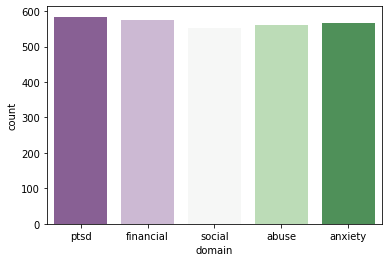

In [0]:
print('Number of train data', len(train))
sns.countplot('domain', data = train, palette='PRGn')

In [0]:
print('Number of train data', len(train))
train['label'].value_counts()

Number of train data 2838


1    1488
0    1350
Name: label, dtype: int64

In [0]:
print('Number of train data', len(test))
test['label'].value_counts()

Number of train data 715


1    369
0    346
Name: label, dtype: int64

When doing the presentation, can add a part of analyzing the text with lexicon-based tool such as textblob

## Data Preprocessing
Possible approach of data preprocessing and feature engineeing 
- Tokenization, Removal of punctuations.
- Removal of commonly used words (stopwords).
- Lemmatization or Stemming (Normalization)

### Tokenization & Remove punctuations
remove punctuations, single letter word, word that contains number...

In [0]:
# tokenization: breaks the string into list of words
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
train['processed_text'] = train['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['processed_text'] = test['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove Stopwords

In [0]:
from tqdm import tqdm
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [ ]:
tqdm.pandas()
train['processed_text'] = train['processed_text'].progress_apply(lambda x: remove_stopwords(x))

In [0]:
test['processed_text'] = test['processed_text'].apply(lambda x: remove_stopwords(x))

In [0]:
train['processed_text'][:5]

0    [said, felt, way, suggeted, go, rest, trigger,...
1    [hey, assistance, sure, right, place, post, go...
2    [mom, hit, newspaper, shocked, would, knows, l...
3    [met, new, boyfriend, amazing, kind, sweet, go...
4    [october, domestic, violence, awareness, month...
Name: processed_text, dtype: object

### Stemming & Lemmatization
Text normalization

In [0]:
# stemming
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_stemmer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_stemmer(x))

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_lemmatizer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_lemmatizer(x))

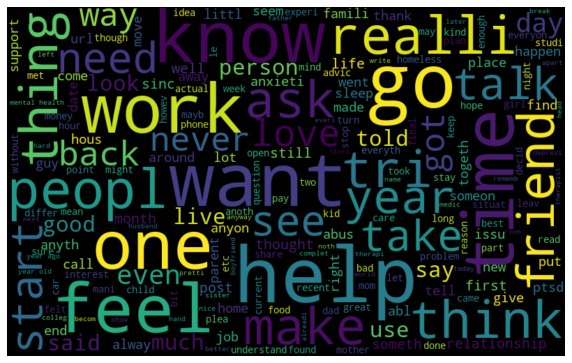

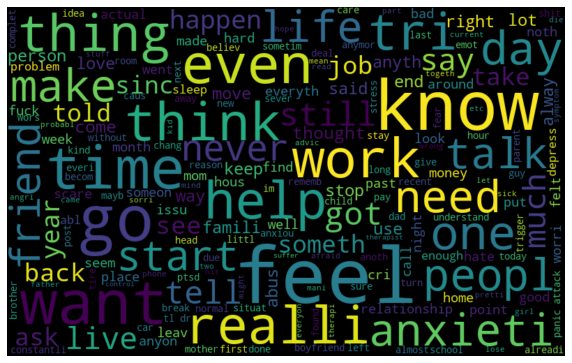

In [0]:
def create_word_cloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

train['processed_text'] = train['processed_text'].apply(lambda x: ' '.join(x))
non_stress_post_words = ' '.join([text for text in train[train['label'] == 0]['processed_text']])
stress_post_words = ' '.join([text for text in train[train['label'] == 1]['processed_text']])

create_word_cloud(non_stress_post_words)
create_word_cloud(stress_post_words)

In [0]:
train['text'].iloc[0]

'He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.'

In [0]:
train['processed_text'].iloc[0]

'said felt way sugget go rest trigger ahead youi hypocondriac like decid look feel doom hope mayb get suck rabbit hole ludicr conspiraci stupid psychic test new age someth could even laugh road end read sen doom indic variou health ailment one prone top doom gloom worri heart happen physic hour'

## Feature Extraction
- vectorization
- bag-of-n-grams
- tf-idf
- word2vec
- word embedding (pretrained
- fasttext 
- glove 

### TF-IDF
Find TF-IDF of unigram, bigram and trigram

In [0]:
path = './data/'
train = pd.read_pickle(path + "train.pkl")
test = pd.read_pickle(path + "test.pkl")

In [6]:
# train_corpus = train['processed_text']
train_corpus = train['processed_text'].apply(lambda x: ' '.join(x))
# test_corpus = test['processed_text']
test_corpus = test['processed_text'].apply(lambda x: ' '.join(x))

In [7]:
X = train_corpus.append(test_corpus)
X = X.reset_index(drop=True)

#### Unigram

In [0]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1)) #bigram
X_new = vectorizer.fit_transform(X)

X_train = X_new.toarray()[:len(train)]
X_test = X_new.toarray()[len(train):]

In [20]:
print(X_train.shape)
print(X_test.shape)

(2838, 7807)
(715, 7807)


In [0]:
def top_tfidf_features(row, features, top_n):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_features = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_features)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_post(data, features, row_id, top_n):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(data[row_id])
    return top_tfidf_features(row, features, top_n)

In [13]:
features = vectorizer.get_feature_names()
top_features_in_post(X_train, features, 0, 10)

,feature,tfidf
0,doom,0.515735
1,gloom,0.197489
2,ludicr,0.197489
3,hypocondriac,0.197489
4,youi,0.197489
5,sugget,0.197489
6,conspiraci,0.197489
7,ailment,0.188049
8,psychic,0.181352
9,rabbit,0.171912


In [0]:
def top_mean_features_by_label(X, y, features, top_n, label_id):
    ids = np.where(y == label_id)
    
    if ids:
        new_data = X[ids]
    else:
        new_data = X


    tfidf_means = np.mean(new_data, axis=0)
    feature_df = top_tfidf_features(tfidf_means, features, top_n)
    feature_df['label'] = label_id

    return feature_df    

In [0]:
non_stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 0)
stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 1)

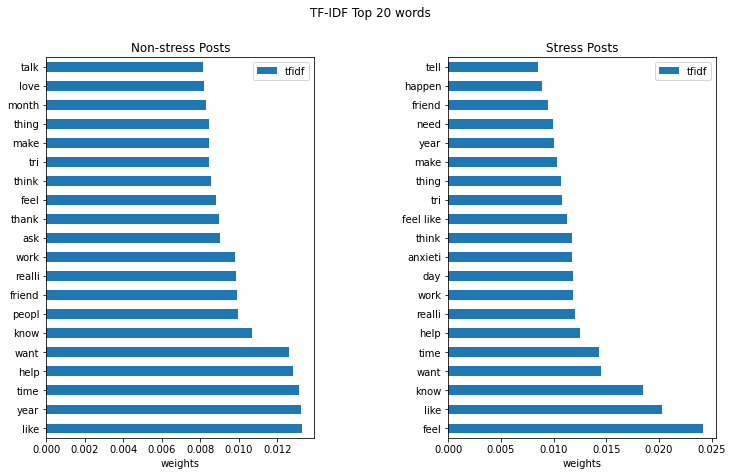

<Figure size 432x288 with 0 Axes>

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
non_stress_df[['feature', 'tfidf']][:20].plot(kind='barh', ax=ax[0])
stress_df[['feature', 'tfidf']][:20].plot(kind='barh', ax=ax[1])

ax[0].set_title('Non-stress Posts')
ax[0].set_xlabel('weights')
ax[0].set_yticklabels(non_stress_df.feature)

ax[1].set_title('Stress Posts')
ax[1].set_xlabel('weights')
ax[1].set_yticklabels(stress_df.feature)


fig.suptitle('TF-IDF Top 20 words')
plt.subplots_adjust(wspace = 0.5)
plt.show()
plt.savefig('./figs/Top_20_words.png')

In [0]:
def create_tfidf_word_cloud(weights):
    wc = WordCloud(width=800, height=500, random_state=21, max_font_size=110)
    wordcloud = wc.generate_from_frequencies(weights)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

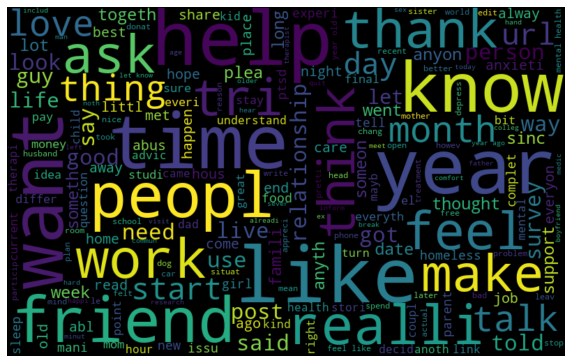

<Figure size 432x288 with 0 Axes>

In [0]:
non_stress_weights = dict(zip(non_stress_df.feature, non_stress_df.tfidf))
create_tfidf_word_cloud(non_stress_weights)
plt.savefig('./figs/non_stress_word_cloud.png')

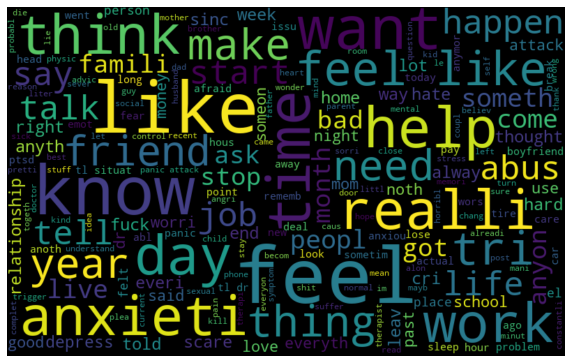

<Figure size 432x288 with 0 Axes>

In [0]:
stress_weights = dict(zip(stress_df.feature, stress_df.tfidf))
create_tfidf_word_cloud(stress_weights)
plt.savefig('./figs/stress_word_cloud.png')

#### Trigram

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) #unigram, bigram, trigram
X_new = vectorizer.fit_transform(X)
X_train = X_new.toarray()[:len(train)]
X_test = X_new.toarray()[len(train):]

In [9]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print(X_train.shape)
print(X_test.shape)

(2838, 200358)
(715, 200358)


In [11]:
X_train.to_pickle("../data/trigram_train.pkl")
X_test.to_pickle("../data/trigram_test.pkl")

## Classification

### Unigram

In [12]:
y_train = train['label']
y_test = test['label']

clf_dict = {'log reg': LogisticRegression(random_state=42), 
            'naive bayes': GaussianNB(), 
            'linear svc': LinearSVC(random_state=42),
            'CART': DecisionTreeClassifier(random_state=42),
            'random forest': RandomForestClassifier(n_estimators=100, random_state=42)}

In [23]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy and F1-score of {}:'.format(name), accuracy_score(y_pred, y_test), f1_score(y_test, y_pred))

Accuracy and F1-score of log reg 0.7440559440559441 0.758893280632411
Accuracy and F1-score of naive bayes 0.544055944055944 0.6014669926650368
Accuracy and F1-score of linear svc 0.7216783216783217 0.7350199733688416
Accuracy and F1-score of CART 0.5832167832167832 0.6119791666666667
Accuracy and F1-score of random forest 0.6993006993006993 0.7412755716004813


#### XGBoost

In [0]:
# on CPU:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
params = {"objective":'multi:softprob','colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10 , 'num_class': 2, 'random_state': 42}
steps = 20  # The number of training iterations
model = xgb.train(params, D_train, steps)
preds = model.predict(D_test)
y_pred = np.asarray([np.argmax(line) for line in preds])

#### Logistic Regression

In [24]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy', accuracy_score(y_pred, y_test))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Accuracy 0.7440559440559441
Precision 0.7384615384615385
Recall 0.7804878048780488
F1-Score 0.758893280632411


In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

### Trigram

In [26]:
# path = './data/'
# X_train = pd.read_pickle(path + "trigram_train.pkl")
# X_test = pd.read_pickle(path + "trigram_test.pkl")

(2838, 200358)

In [13]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy and F1-score of {}'.format(name), accuracy_score(y_pred, y_test), f1_score(y_test, y_pred))

/Users/Evangeline0519/miniconda3/envs/36env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy and F1-score of log reg 0.7244755244755244 0.7629362214199759


KeyboardInterrupt: 

In [0]:
clf = LinearSVC(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7314685314685314

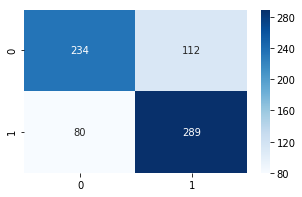

In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [0]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

/Users/gillianchiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7062937062937062

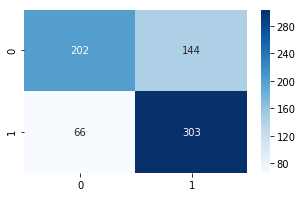

In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [0]:
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Precision 0.7206982543640897
Recall 0.7831978319783198
F1-Score 0.7506493506493507
